In [1113]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

We simulate embedding an entity to the answer space directly. So the query is dependent on only one entity!

In [1114]:

def plot_embeddings(embs):
    embs_temp = embs.clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.view_init(25, 10)

    # plot embeddings
    for emb in embs_temp:
        ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='blue')

In [1300]:
"""Simple MLP model with 2 layers, simulating GCN model"""
class MLP(nn.Module):
    def __init__(self, num_bands, band_size, batch_size):
        super().__init__()
        self.num_bands = num_bands
        self.band_size = band_size
        self.embs = torch.nn.parameter.Parameter(data=torch.randn((batch_size, 3)))
        self._normalize()
        firstlayer = 3 * num_bands
        secondlayer = firstlayer * band_size
        self.layers = nn.Sequential(
            nn.Linear(3, firstlayer),
            nn.ReLU(),
            nn.Linear(firstlayer, secondlayer)
        )

    def _normalize(self):
        self.embs.data = F.normalize(self.embs.data)
        
    def forward(self, input):
        # in: (batch_size, embed_dim)
        # out: (batch_size, num_bands, band_size, embed_dim)
        x = self.layers(input)
        return x.reshape(input.size(0), self.num_bands, self.band_size, input.size(1))

In [1301]:
"""
Function that shuffles indexes (duplicates allowed) where at least we know
the new index is NOT the original index!
"""
def shuffled_indices(max_index):
    out = []
    for idx in range(max_index):
        out.append(random.choice([x for x in range(max_index) if not x == idx]))
    return out

shuffled_indices(20)


[7, 17, 17, 15, 6, 9, 5, 17, 6, 12, 6, 14, 13, 7, 10, 9, 6, 8, 14, 11]

In [1302]:
def plot_answerspace(embs, space, batch_id=0):

    present = 0
    example_id = 0
    also_present = []
    for band_id in range(4):
        if torch.all(torch.sum(embs[batch_id] * space[batch_id][band_id], dim=-1) > 0):
            present += 1
            example_id = band_id   

            # see which embeddings are also present
            also_present = []
            # embs:     (num_ents, embed_dim)
            # space:    (batch, num_bands, band_size, embed_dim)
            embs_1 = embs.reshape(embs.size(0), 1, embs.size(1))                          # (num_ents, 1, embed_dim)
            space_1 = space[batch_id][band_id].reshape(1, space.size(2), space.size(3))   # (1, band_size, embed_dim)
            dot_inds = (torch.sum(embs_1 * space_1, dim=-1) > 0)
            ent_inds = torch.all(dot_inds, dim=-1)
            for ent_id, ent_ind in enumerate(ent_inds):
                if ent_ind and (ent_id != batch_id):
                    also_present.append(embs[ent_id].clone().detach().tolist())

    print(f"Present in {present} bands, example of true (if present):")

    emb = embs[batch_id].clone().detach().tolist()
    hyps = space[batch_id][example_id].clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.view_init(25, 10)

    # plot target embedding
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='green')

    # plot normal vectors
    for hyp in hyps:
        ax.quiver(0, 0, 0, hyp[0], hyp[1], hyp[2], color='blue')

    if also_present:
        for vec in also_present:
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='red')

In [1303]:
def predict(embs, space):
    answers = [[] for _ in range(embs.size(0))]

    space_1 = space.reshape(space.size(0), 1, space.size(1), space.size(2), space.size(3))          
    
    # add extra dimension for broadcasting:  
    # from  (num_ents_mode, embed_dim)
    # to    (1, num_ents_mode, 1, 1, embed_dim)
    embs_1 = embs.reshape(1, embs.size(0), 1, 1, embs.size(1))

    # calculate dot products of hyperplanes-embeddings
    # and convert positive/negative dot products to binary values
    # shape: (batch_size_mode, num_ents_mode, num_bands, band_size)
    dot_inds = (torch.sum(space_1 * embs_1, dim=-1) > 0)

    # only if all hyperplanes in a band are positive and the band contains the answer
    # shape: (batch_size_mode, num_ents_mode, num_bands)
    band_inds = torch.all(dot_inds, dim=-1)

    # if any band contains the entity, then the entity is a predicted answer
    # shape: (batch_size_mode, num_ents_mode)
    ent_inds = torch.any(band_inds, dim=-1)

    # iterate through all batches
    for batch_idx, batch in enumerate(ent_inds):
        # for all entities for that batch
        for ent_idx, ent_ind in enumerate(batch):
            # if the entity indicator is True (is in any band's answer space)
            if ent_ind:
                # we add the global entity index (=ID) to the answer list for that batch
                answers[batch_idx].append(ent_idx)
    return answers


In [1304]:
cos = torch.nn.CosineSimilarity(dim=-1)

In [1308]:
def hyp_diversity(hyp):

    # generate random pairs
    rand_idx = shuffled_indices(hyp.size(2))
    rand_hyp = hyp[:, :, rand_idx, :]

    # calculate dot products
    rand_dot_norm = cos(hyp, rand_hyp)

    # calculate diversity per band
    band_div = torch.mean(rand_dot_norm, dim=-1)

    # return mean diversity for all bands
    return torch.mean(band_div, dim=-1)


In [1313]:
def loss_function(hyp, embs, negs, div_penalty=False):
    # hyp shape:    (batch, num_bands, band_size, embed_dim)
    # embs shape:   (batch, embed_dim)
    # negs shape:   (batch, embed_dim)

    pos_ = embs.reshape(embs.size(0), 1, 1, embs.size(1))           # shape: (batch, 1, 1, embed_dim)
    pos_dot_norm = cos(pos_, hyp)                                   # shape: (batch, num_bands, band_size)

    neg_ = negs.reshape(negs.size(0), 1, 1, negs.size(1))           # shape: (batch, 1, 1, embed_dim)
    neg_dot_norm = cos(neg_, hyp)                                   # shape: (batch, num_bands, band_size)

    # calculate band distance:
    # we only need one of the dot products of the negative sample to be negative,
    # but we need all positive samples to be positive
    pos_distance = -torch.mean(pos_dot_norm, dim=-1)
    neg_distance = -torch.min(neg_dot_norm, dim=-1).values

    # aggregate band distances:
    # we only need one band to contain the positive sample,
    # but we need all bands to exclude the negative sample
    band_min = torch.min(pos_distance, dim=-1)
    pos_loss, pos_idx = band_min.values, band_min.indices
    neg_loss = torch.mean(neg_distance, dim=-1)

    div_loss = hyp_diversity(hyp) if div_penalty else torch.tensor(0, dtype=torch.float)

    # calculate margin loss
    loss = pos_loss - neg_loss + div_loss
    return torch.mean(loss), torch.mean(pos_loss).detach().item(), torch.mean(neg_loss).detach().item(), torch.mean(div_loss).detach().item()

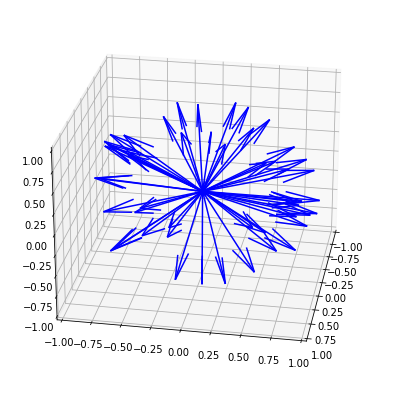

In [1324]:
NUM_BANDS = 4
BAND_SIZE = 6
BATCH_SIZE = 50

model = MLP(
    num_bands=NUM_BANDS,
    band_size=BAND_SIZE,
    batch_size=BATCH_SIZE
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# show initial random embeddings
plot_embeddings(model.embs)

100 | Loss: -1.643, pos_loss:-0.847, neg_loss:0.865, div_loss:0.069
200 | Loss: -1.729, pos_loss:-0.839, neg_loss:0.874, div_loss:-0.016
300 | Loss: -1.887, pos_loss:-0.859, neg_loss:0.883, div_loss:-0.144
400 | Loss: -1.757, pos_loss:-0.866, neg_loss:0.878, div_loss:-0.012
500 | Loss: -1.816, pos_loss:-0.848, neg_loss:0.885, div_loss:-0.082
600 | Loss: -1.676, pos_loss:-0.858, neg_loss:0.865, div_loss:0.047
700 | Loss: -1.636, pos_loss:-0.871, neg_loss:0.877, div_loss:0.112
800 | Loss: -1.717, pos_loss:-0.855, neg_loss:0.870, div_loss:0.008
900 | Loss: -1.858, pos_loss:-0.821, neg_loss:0.900, div_loss:-0.138
1000 | Loss: -1.610, pos_loss:-0.831, neg_loss:0.878, div_loss:0.098


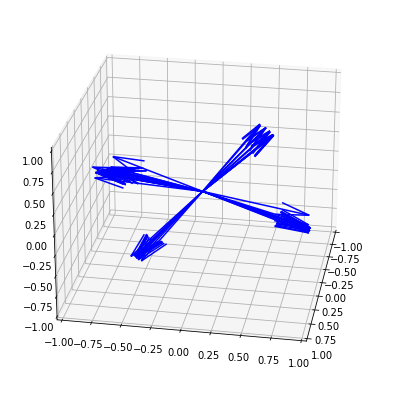

In [1334]:
# training loop
for step in range(1000):

    # sample negative embeddings that is NOT equal to original index :-)
    neg_idx = shuffled_indices(model.embs.size(0))
    negs = model.embs[neg_idx, :]

    optimizer.zero_grad()
    hyps = model(model.embs)
    loss, p, n, d = loss_function(hyps, model.embs, negs, div_penalty=True)
    loss.backward()
    optimizer.step()

    # normalize embeddings each step
    model._normalize()

    if (step + 1) % 100 == 0:
        print(f"{step+1} | Loss: {loss.detach().item():.3f}, pos_loss:{p:.3f}, neg_loss:{n:.3f}, div_loss:{d:.3f}")

# plot all embs
plot_embeddings(model.embs)

In [1326]:
pred = predict(model.embs, hyps)
for true_idx, b in enumerate(pred):
    print(f"Contains answer: {(true_idx in b)}, len: {len(b)}")

Contains answer: True, len: 10
Contains answer: True, len: 16
Contains answer: False, len: 4
Contains answer: True, len: 7
Contains answer: True, len: 14
Contains answer: True, len: 17
Contains answer: True, len: 7
Contains answer: False, len: 3
Contains answer: True, len: 5
Contains answer: False, len: 3
Contains answer: True, len: 9
Contains answer: True, len: 13
Contains answer: True, len: 11
Contains answer: True, len: 4
Contains answer: True, len: 17
Contains answer: True, len: 15
Contains answer: True, len: 15
Contains answer: True, len: 10
Contains answer: True, len: 16
Contains answer: True, len: 16
Contains answer: True, len: 13
Contains answer: True, len: 9
Contains answer: True, len: 16
Contains answer: True, len: 15
Contains answer: True, len: 15
Contains answer: True, len: 3
Contains answer: True, len: 12
Contains answer: False, len: 2
Contains answer: True, len: 9
Contains answer: True, len: 13
Contains answer: True, len: 20
Contains answer: True, len: 11
Contains answer:

Present in 1 bands, example of true (if present):


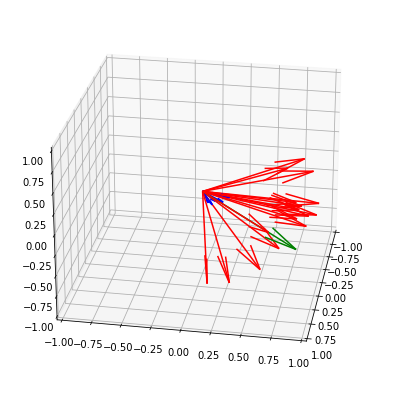

In [1332]:
# plot one example with hyperplanes
id1 = random.randint(0, BATCH_SIZE-1)
plot_answerspace(model.embs, hyps, batch_id=id1)